In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import f_oneway
import glob

In [32]:
def count_feature_files(directory):
    # Count .npy files
    npy_files = len(glob.glob(os.path.join(directory, 'features_*.npy')))
    
    # Count .json files
    json_files = len(glob.glob(os.path.join(directory, 'features_*_metadata.json')))
    
    return npy_files, json_files

# Example usage
directory = '/home/carlos/Documents/fingerprint/features/cell_39'
npy_count, json_count = count_feature_files(directory)

print(f"Number of .npy files: {npy_count}")
print(f"Number of .json files: {json_count}")

Number of .npy files: 5912
Number of .json files: 5912


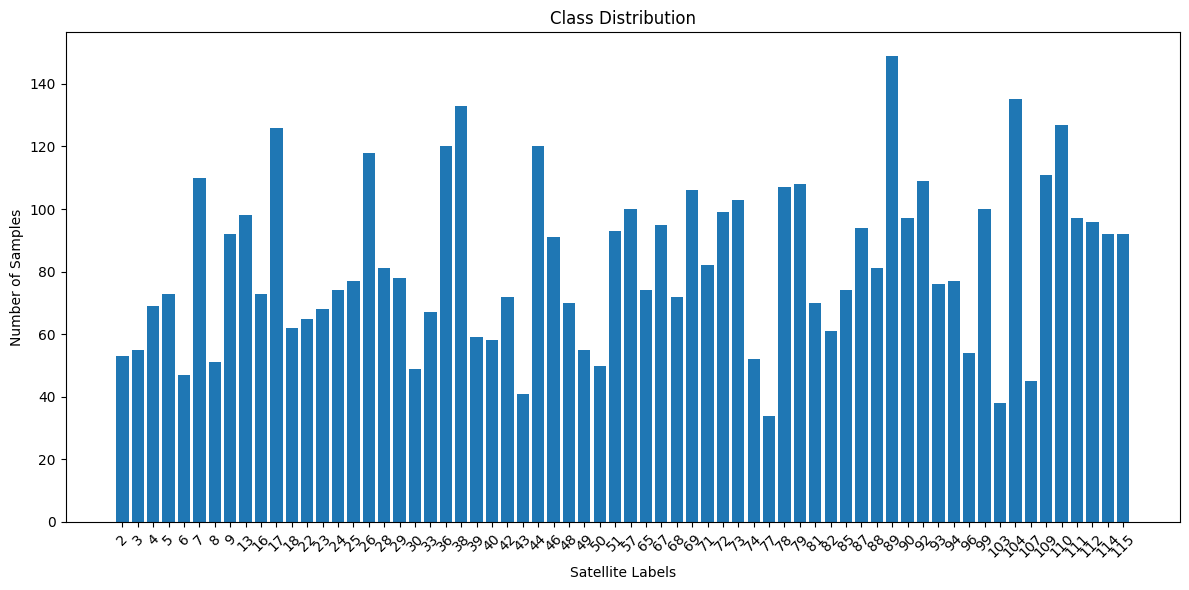

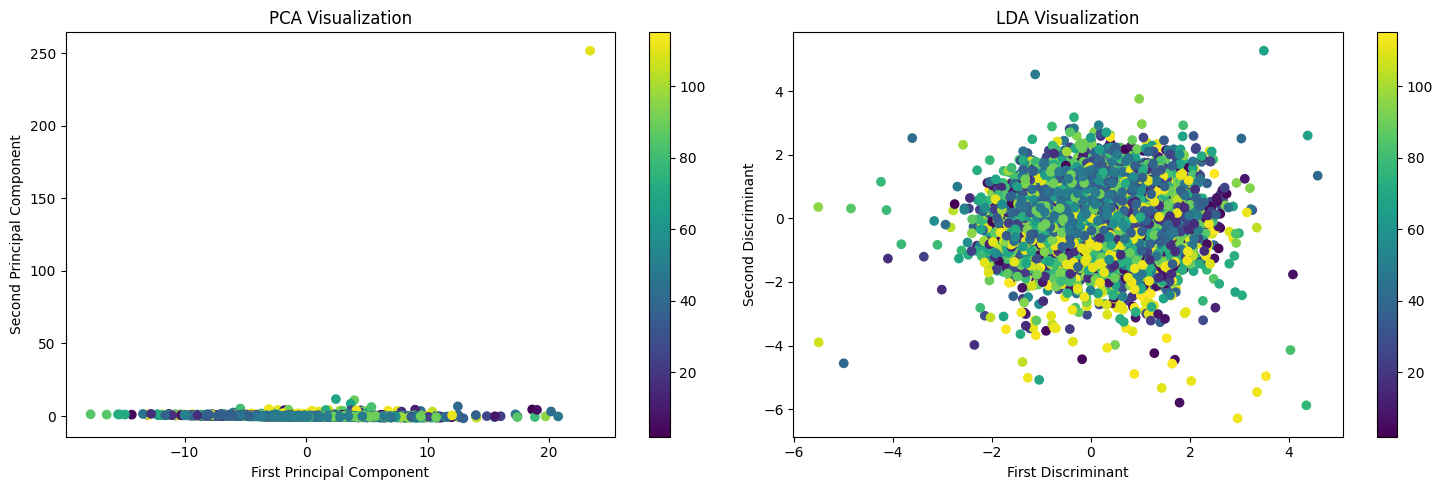


--- Dataset Summary ---
Total Samples: 5455
Number of Unique Satellite Labels: 66

--- Class Distribution ---
Satellite Label 2: 53 samples (0.97%)
Satellite Label 3: 55 samples (1.01%)
Satellite Label 4: 69 samples (1.26%)
Satellite Label 5: 73 samples (1.34%)
Satellite Label 6: 47 samples (0.86%)
Satellite Label 7: 110 samples (2.02%)
Satellite Label 8: 51 samples (0.93%)
Satellite Label 9: 92 samples (1.69%)
Satellite Label 13: 98 samples (1.80%)
Satellite Label 16: 73 samples (1.34%)
Satellite Label 17: 126 samples (2.31%)
Satellite Label 18: 62 samples (1.14%)
Satellite Label 22: 65 samples (1.19%)
Satellite Label 23: 68 samples (1.25%)
Satellite Label 24: 74 samples (1.36%)
Satellite Label 25: 77 samples (1.41%)
Satellite Label 26: 118 samples (2.16%)
Satellite Label 28: 81 samples (1.48%)
Satellite Label 29: 78 samples (1.43%)
Satellite Label 30: 49 samples (0.90%)
Satellite Label 33: 67 samples (1.23%)
Satellite Label 36: 120 samples (2.20%)
Satellite Label 38: 133 samples (2.

In [24]:


class DatasetAnalyzer:
    def __init__(self, data_path='/home/carlos/Documents/fingerprint/features/cell_39'):
        """
        Initialize Dataset Analyzer
        Args:
            data_path (str): Path to directory containing .npy and metadata files
        """
        self.data_path = data_path
        self.feature_names = [
            'power', 'entropy', 'spectral_centroid', 
            'psd_mean', 'psd_variance', 'l_band', 
            'h_band', 'frequency_peak', 'Magnitude_peak'
        ]
    
    def load_data(self, start_idx=1, end_idx=npy_count):
        """
        Load data from .npy files
        
        Returns:
            tuple: X (features), y (labels), feature_matrices
        """
        X, y, feature_matrices = [], [], []
        
        for idx in range(start_idx, end_idx + 1):
            try:
                npy_file = os.path.join(self.data_path, f'features_{idx}.npy')
                metadata_file = os.path.join(self.data_path, f'features_{idx}_metadata.json')
                
                # Skip if files don't exist
                if not (os.path.exists(npy_file) and os.path.exists(metadata_file)):
                    continue
                
                # Load features
                features = np.load(npy_file)
                
                # Load metadata
                with open(metadata_file, 'r') as f:
                    metadata = json.load(f)
                
                feature_matrices.append(features)
                X.append(features.flatten())
                y.append(metadata['Satellite_Label'])
            
            except Exception as e:
                print(f"Error processing file {idx}: {e}")
        
        return np.array(X), np.array(y), feature_matrices
    
    def evaluate_class_balance(self, y):
        """
        Evaluate class balance in the dataset
        
        Args:
            y (np.array): Labels
        
        Returns:
            dict: Class balance information
        """
        # Count occurrences of each class
        unique_labels, counts = np.unique(y, return_counts=True)
        
        # Calculate class distribution
        total_samples = len(y)
        class_distribution = dict(zip(unique_labels, counts / total_samples * 100))
        
        # Visualize class distribution
        plt.figure(figsize=(12, 6))
        plt.bar(unique_labels.astype(str), counts)
        plt.title('Class Distribution')
        plt.xlabel('Satellite Labels')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Calculate imbalance metrics
        max_samples = max(counts)
        min_samples = min(counts)
        imbalance_ratio = max_samples / min_samples
        
        return {
            'unique_labels': unique_labels,
            'samples_per_label': dict(zip(unique_labels, counts)),
            'percentage_distribution': class_distribution,
            'imbalance_ratio': imbalance_ratio
        }
    
    def evaluate_feature_distinctiveness(self, feature_matrices, y):
        """
        Evaluate feature distinctiveness across different satellite labels
        
        Args:
            feature_matrices (list): List of feature matrices
            y (np.array): Labels
        
        Returns:
            dict: Feature distinctiveness analysis
        """
        # Prepare data for analysis
        X_full = np.array([matrix.flatten() for matrix in feature_matrices])
        
        # Perform One-Way ANOVA to test feature significance
        anova_results = {}
        for feature_idx in range(X_full.shape[1]):
            feature_values = [X_full[y == label, feature_idx] for label in np.unique(y)]
            f_statistic, p_value = f_oneway(*feature_values)
            anova_results[self.feature_names[feature_idx % len(self.feature_names)]] = {
                'f_statistic': f_statistic,
                'p_value': p_value
            }
        
        # Dimensionality Reduction for Visualization
        # PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_full)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        # LDA
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_lda = lda.fit_transform(X_scaled, y)
        
        # Visualization
        plt.figure(figsize=(15, 5))
        
        # PCA Plot
        plt.subplot(121)
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
        plt.title('PCA Visualization')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.colorbar(scatter)
        
        # LDA Plot
        plt.subplot(122)
        scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis')
        plt.title('LDA Visualization')
        plt.xlabel('First Discriminant')
        plt.ylabel('Second Discriminant')
        plt.colorbar(scatter)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'anova_results': anova_results,
            'pca_variance_ratio': pca.explained_variance_ratio_
        }
    
    def comprehensive_dataset_analysis(self, start_idx=1, end_idx=npy_count):
        """
        Perform comprehensive dataset analysis
        
        Args:
            start_idx (int): Start index for feature matrices
            end_idx (int): End index for feature matrices
        
        Returns:
            dict: Comprehensive analysis results
        """
        # Load data
        X, y, feature_matrices = self.load_data(start_idx, end_idx)
        
        # Class Balance Analysis
        class_balance = self.evaluate_class_balance(y)
        
        # Feature Distinctiveness
        feature_distinctiveness = self.evaluate_feature_distinctiveness(feature_matrices, y)
        
        # Print summary
        print("\n--- Dataset Summary ---")
        print(f"Total Samples: {len(X)}")
        print(f"Number of Unique Satellite Labels: {len(class_balance['unique_labels'])}")
        print("\n--- Class Distribution ---")
        for label, count in class_balance['samples_per_label'].items():
            print(f"Satellite Label {label}: {count} samples ({class_balance['percentage_distribution'][label]:.2f}%)")
        
        print("\n--- Feature Distinctiveness (ANOVA) ---")
        for feature, result in feature_distinctiveness['anova_results'].items():
            print(f"{feature}: F-statistic = {result['f_statistic']:.4f}, p-value = {result['p_value']:.4f}")
        
        return {
            'class_balance': class_balance,
            'feature_distinctiveness': feature_distinctiveness
        }

# Main execution
def main():
    try:
        # Initialize analyzer
        analyzer = DatasetAnalyzer()
        
        # Perform comprehensive analysis
        analysis_results = analyzer.comprehensive_dataset_analysis()
    
    except Exception as e:
        print(f"An error occurred: {e}")

# Run the script
if __name__ == "__main__":
    main()

Dataset balance for Satellite_Label:
Label 40: 58
Label 4: 103
Label 43: 87
Label 72: 99
Label 77: 58
Label 57: 100
Label 111: 120
Label 89: 149
Label 44: 120
Label 104: 147
Label 36: 120
Label 81: 70
Label 67: 95
Label 29: 78
Label 79: 108
Label 69: 106
Label 114: 136
Label 7: 110
Label 74: 52
Label 8: 52
Label 48: 70
Label 28: 134
Label 94: 79
Label 13: 98
Label 96: 54
Label 109: 111
Label 87: 94
Label 17: 126
Label 26: 123
Label 23: 96
Label 33: 67
Label 93: 130
Label 99: 100
Label 112: 96
Label 42: 72
Label 71: 82
Label 5: 94
Label 38: 133
Label 78: 107
Label 85: 74
Label 92: 109
Label 3: 73
Label 39: 91
Label 50: 50
Label 82: 61
Label 68: 72
Label 115: 92
Label 90: 97
Label 88: 81
Label 73: 103
Label 30: 49
Label 18: 62
Label 51: 97
Label 24: 74
Label 9: 93
Label 110: 127
Label 22: 72
Label 25: 77
Label 2: 53
Label 6: 49
Label 65: 74
Label 103: 68
Label 107: 45
Label 16: 73
Label 46: 91
Label 49: 63


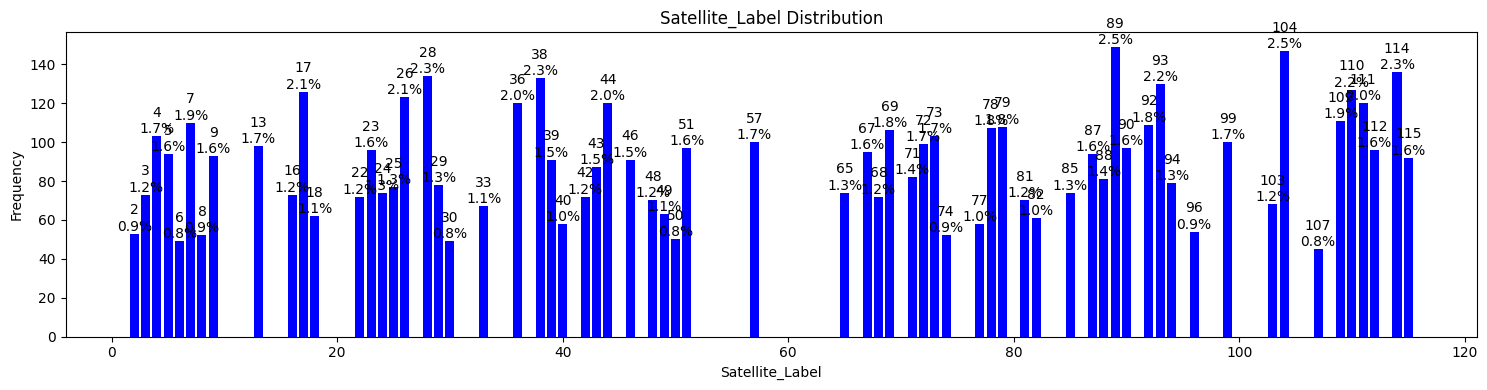


Imbalance Indices:
Imbalance Ratio (max frequency / min frequency): 3.31
Normalized Entropy (0 = imbalanced, 1 = balanced): 0.99


In [26]:
import os
import glob
import json
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import math

def evaluate_balance(metadata_dir):
    """
    Evaluate the dataset balance by counting the occurrences of each Satellite_Label
    in metadata files located in metadata_dir.
    
    Parameters:
    - metadata_dir (str): Directory containing the metadata JSON files.
    
    Returns:
    - Counter: A dictionary-like object with the Satellite_Label as keys and their counts as values.
    """
    # Find all metadata JSON files matching the pattern
    metadata_files = glob.glob(os.path.join(metadata_dir, "features_*_metadata.json"))
    label_counter = Counter()
    
    # Process each metadata file
    for metadata_file in metadata_files:
        try:
            with open(metadata_file, 'r') as f:
                metadata = json.load(f)
            # Get the Satellite_Label from metadata
            label = metadata.get("Satellite_Label")
            if label is not None:
                label_counter[label] += 1
            else:
                print(f"Warning: 'Satellite_Label' not found in {metadata_file}")
        except Exception as e:
            print(f"Error reading {metadata_file}: {e}")
    
    return label_counter

def plot_balance(counter):
    """
    Plot a bar chart for the label distribution. Each column shows the percentage of total signals
    along with the Satellite_Label.
    
    Parameters:
    - counter (Counter): A Counter object containing the label frequencies.
    """
    labels = list(counter.keys())
    counts = list(counter.values())
    total = sum(counts)
    
    # Create the bar chart
    plt.figure(figsize=(15, 4))
    bars = plt.bar(labels, counts, color='blue')
    plt.xlabel('Satellite_Label')
    plt.ylabel('Frequency')
    plt.title('Satellite_Label Distribution')
    
    # Annotate each bar with the label and percentage of total signals
    for bar, label, count in zip(bars, labels, counts):
        percentage = (count / total) * 100
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height(), 
            f"{label}\n{percentage:.1f}%", 
            ha='center', 
            va='bottom'
        )
    
    plt.tight_layout()
    plt.show()

def compute_imbalance_indices(counter):
    """
    Compute imbalance indices from the label frequencies.
    
    Parameters:
    - counter (Counter): A Counter object containing the label frequencies.
    
    Returns:
    - dict: A dictionary with computed indices.
        - imbalance_ratio: Ratio between the maximum and minimum frequencies.
        - entropy: Normalized entropy of the distribution (0 to 1 scale, where 1 is perfectly balanced).
    """
    counts = np.array(list(counter.values()))
    # Compute imbalance ratio (avoid division by zero)
    if counts.min() > 0:
        imbalance_ratio = counts.max() / counts.min()
    else:
        imbalance_ratio = float('inf')
    
    # Compute normalized entropy
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log(probabilities))
    max_entropy = np.log(len(probabilities))
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
    return {
        "imbalance_ratio": imbalance_ratio,
        "entropy": normalized_entropy
    }

if __name__ == "__main__":
    # Set the directory where the metadata files are stored
    metadata_directory = "/home/carlos/Documents/fingerprint/features/cell_39"  # Change this path if your files are in a different folder
    
    # Evaluate the dataset balance
    balance = evaluate_balance(metadata_directory)
    
    print("Dataset balance for Satellite_Label:")
    for label, count in balance.items():
        print(f"Label {label}: {count}")
    
    # Plot the distribution with annotated percentages
    plot_balance(balance)
    
    # Compute imbalance indices
    indices = compute_imbalance_indices(balance)
    print("\nImbalance Indices:")
    print(f"Imbalance Ratio (max frequency / min frequency): {indices['imbalance_ratio']:.2f}")
    print(f"Normalized Entropy (0 = imbalanced, 1 = balanced): {indices['entropy']:.2f}")

